## A2 - Archetypal analysis for pathology atlas

This notebook demonstrates how to build **Spatial Functional archetypes** on TCGA pancaner datasets by a pathology atlas. And how to extend the SFA into other datasets.  
The processed TCGA datasets by PASTA and atlas can be downloaded from [Zenodo](https://zenodo.org/uploads/17484051).

### 1. SFA identification

In [ ]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pasta.AA import AA_Fast, run_build_aa

In [ ]:
adata = sc.read_h5ad('/workspace/results/AA/TCGA_atlas_scale_banksy.h5ad')
adata

AnnData object with n_obs × n_vars = 44444 × 14
    obs: 'sample', 'cluster', 'tumor_type', 'tissue_id', 'archetype'
    uns: 'archetype_colors', 'dendrogram_archetype', 'neighbors', 'tumor_type_colors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

#### Archetypal analysis

The downloaded aggregated atlas already contains `archetype` labels. The following steps are optional and intended only to reproduce the SFA identification process.

In [ ]:
# k=(2,10) to find optimal k with lowest RSS
trans_x_raw, archetypes_dict_raw, reconstruction_errors_raw = run_build_aa(adata.X)

k = 2; RSS = 297469.3415
k = 3; RSS = 210277.3248
k = 4; RSS = 171691.8017
k = 5; RSS = 116936.2646
k = 6; RSS = 180030.8604
k = 7; RSS = 99621.8527
k = 8; RSS = 186042.0858
k = 9; RSS = 167431.7879
k = 10; RSS = 177504.6302


or you can directly load:

In [ ]:
with open(f'/workspace/results/AA/trans_x_AA.pkl', "rb") as f:
    trans_x_raw = pickle.load(f)
with open(f'/workspace/results/AA/archetypes_AA.pkl', "rb") as f:
    archetypes_dict_raw = pickle.load(f)
with open(f'/workspace/results/AA/reconstruction_errors_AA.pkl', "rb") as f:
    reconstruction_errors_raw = pickle.load(f)

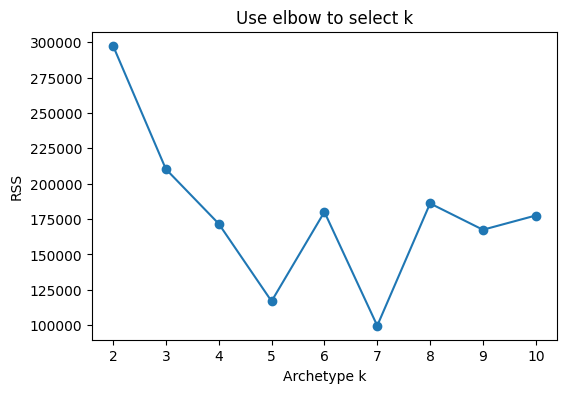

In [ ]:
k_range = range(2, 11)  
plt.figure(figsize=(6, 4))
plt.plot(list(k_range), reconstruction_errors_raw, marker='o')
plt.xlabel("Archetype k")
plt.ylabel("RSS")
plt.title("Use elbow to select k")
plt.show()

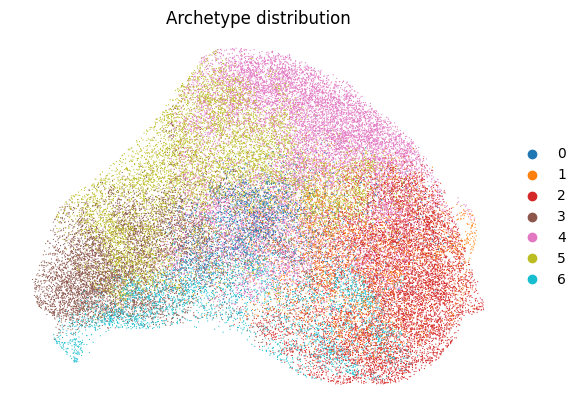

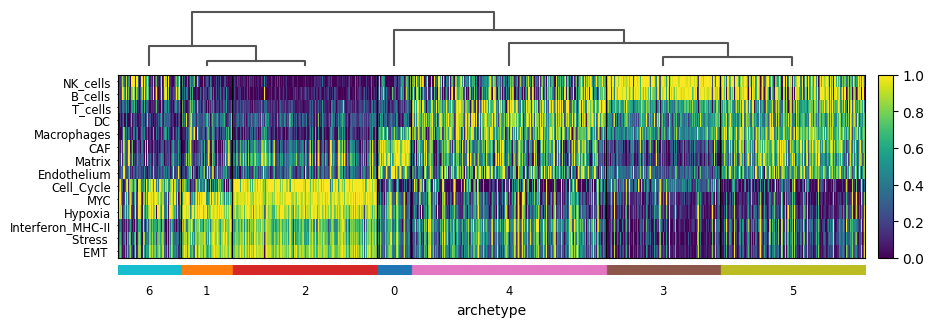

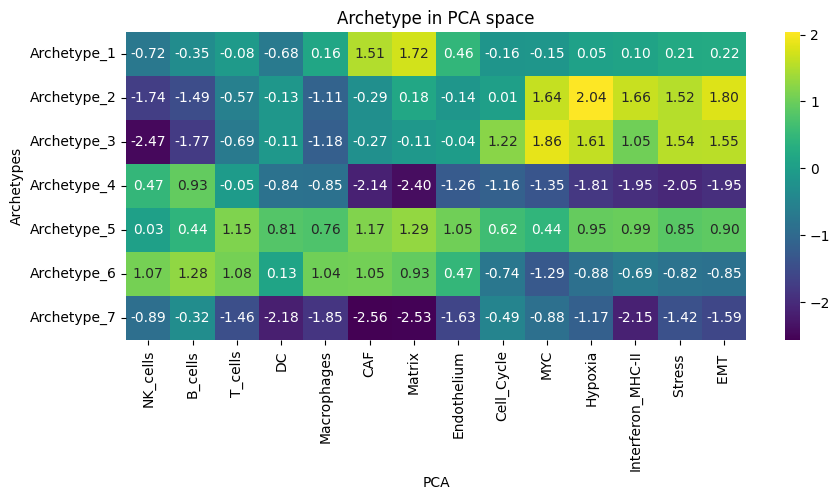

In [ ]:
k = 7
cell_archetype = np.argmax(trans_x_raw[k], axis=1)
adata.obs['archetype'] = cell_archetype.astype(str)

# 1. SFA umap
sc.pl.embedding(adata, basis='umap', color='archetype', title=f'Archetype distribution', frameon=False)

# 2. Archetype signatures on pathways
sc.tl.dendrogram(adata, groupby='archetype')
sc.pl.heatmap(adata,
              var_names= ['NK_cells','B_cells', 'T_cells','DC', 'Macrophages', 'CAF', 'Matrix', 'Endothelium', 
                 'Cell_Cycle', 'MYC','Hypoxia', 'Interferon_MHC-II',  'Stress ', 'EMT '],
              groupby='archetype', 
              standard_scale='obs',    
              dendrogram=True,        
              swap_axes=True,         
              show=True)

archetypes_df = pd.DataFrame(archetypes_dict_raw[k], columns= adata.var_names)
archetypes_df.index = [f'Archetype_{i}' for i in range(1, k+1)]

# 3. Archetypal analysis weight heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(archetypes_df[['NK_cells','B_cells', 'T_cells','DC', 'Macrophages', 'CAF', 'Matrix', 'Endothelium', 
                 'Cell_Cycle', 'MYC','Hypoxia', 'Interferon_MHC-II',  'Stress ', 'EMT ']], cmap="viridis", annot=True, fmt=".2f")
plt.title("Archetype in PCA space")
plt.xlabel("PCA")
plt.ylabel("Archetypes")
plt.show()

### 2. Sample level SFA scores

The sample-level SFA scores are calculated at three steps as follows. For detailed mathematical formulas, please refer to the **Methods** section of the PASTA paper.
1. Cluster-area percentile 
2. Neighborhood enrichment matrix
3. Archetype aggregation  

Similarly, the following steps are optional and are intended only to reproduce the analysis. The computed results `feature_ab`, `feature_aa`, `feature_ne` are already available under `/workspace/results/AA/`.

In [ ]:
!pip install squidpy

In [ ]:
import squidpy as sq
from tqdm import tqdm
from multiprocessing import Pool

In [ ]:
def calculate_features_single_sample(sample_path,k=7):
    sample_id = os.path.basename(sample_path).split('.')[0]
    h5ad_tmp = sc.read_h5ad(sample_path)
    h5ad_tmp.obs['communities_Banksy_'] = [f'cluster_{item}' for item in h5ad_tmp.obs['scaled_gaussian_pc16_nc0.20_r0.70']]
    h5ad_tmp_map = adata_14[adata_14.obs['sample'] == sample_id].copy()

    h5ad_tmp.obs['communities_Banksy_'] = h5ad_tmp.obs['communities_Banksy_'].astype("category")
    
    counts_community = h5ad_tmp.obs.value_counts(subset='communities_Banksy_').to_dict()
    k_community = len(counts_community)
    
    feature_ab = {f'cluster_{i}': 0 for i in range(k_community)}
    for key, value in counts_community.items():
        feature_ab[key] = value
    
    # AA scores
    mask = adata_14.obs["sample"] == sample_id
    row_positions = np.where(mask)[0].tolist()
    feature_aa = {f'cluster_{i}': trans_x_raw[k][row_positions][i] for i in range(k_community)}

    # nhood_enrichment
    h5ad_tmp.obsm['spatial'] = h5ad_tmp.obs[['x_pixel', 'y_pixel']]
    sq.gr.spatial_neighbors(h5ad_tmp)
    sq.gr.nhood_enrichment(
        h5ad_tmp, 
        cluster_key= 'communities_Banksy_', 
        show_progress_bar=False
    )
    feature_ne = h5ad_tmp.uns['communities_Banksy__nhood_enrichment']['zscore']
    
    return sample_id, feature_ab, feature_aa, feature_ne

In [ ]:
# mp
def process_all_samples(pancan_file_list_banksy):
    with Pool(processes=4) as pool:
        for result in tqdm(pool.imap_unordered(process_sample, pancan_file_list_banksy), total=len(pancan_file_list_banksy)):
            if result is None:
                continue
            sample_id, ab, aa, ne = result
            feature_ab[sample_id] = ab
            feature_aa[sample_id] = aa
            feature_ne[sample_id] = ne
    
    return feature_ab, feature_aa, feature_ne, bad_sample

In [ ]:
pancan_file_list_banksy = glob.glob('/workspace/results/AA/TCGA/*/*.h5ad')

The directory `/workspace/results/AA/TCGA/` contains the spot-level inference results for slides across 16 cancer datasets from TCGA, organized in the following structure.

```
/workspace/results/AA/TCGA/  
├──CESC/  
│   ├── TCGA-4J-AA1J-01Z-00-DX1.8E768211-46FC-45A4-8689-6DDEA0198D43.h5ad  
│   ├── TCGA-BI-A0VR-01Z-00-DX1.69847920-5A6E-4318-9AD8-6EC9EECD1B3A.h5ad  
│   └── ...
├──STAD/  
│   ├── TCGA-XX-XXXX-XXX-XX-XXX.XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX.h5ad  
│   └── ...
├──KICH/  
│   └── ...  
└── ...   
```

In [ ]:
feature_ab, feature_aa, feature_ne, bad_sample = process_all_samples(pancan_file_list_banksy)

In [ ]:
# directly load
with open(f'/workspace/results/AA/feature_ab_community.pkl', "rb") as f:
    feature_ab = pickle.load(f)
with open(f'/workspace/results/AA/feature_ne_community.pkl', "rb") as f:
    feature_ne = pickle.load(f)
with open(f'/workspace/results/AA/feature_aa_community.pkl', "rb") as f:
    feature_aa = pickle.load(f)

Next, combine the three features `feature_ab`, `feature_aa` and `feature_ne` into sample-level SFA scores

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [ ]:
sample_weighted_aa_ne = []
sample_names = []
k=7

for sample_path in tqdm(pancan_file_list_h5ad):
    sample_id = os.path.basename(sample_path).split('.')[0]
    ab = list(feature_ab[sample_id].values())
    ab_norm = ab/np.sum(ab)
    
    ne = feature_ne[sample_id]
    if np.isnan(ne).any():
        np.nan_to_num(ne,False, 0)
    if not np.isfinite(ne).all():
        finite_mask = np.isfinite(ne)
        max_finite = np.max(ne[finite_mask])
        ne[np.isinf(ne)] = max_finite*1.1  

    scaler = MinMaxScaler()
    features_ne_norm = scaler.fit_transform(ne)
    
    mask = adata.obs["sample"] == sample_id
    row_positions = np.where(mask)[0].tolist()
    aa_trans = trans_x_raw[k][row_positions]
    if len(ab)!=len(row_positions):
        print(sample_path)
    else:
        sample_weighted_aa_ne.append(ab_norm.reshape(1, -1)@ features_ne_norm @ aa_trans)
        sample_names.append(sample_id)

In [ ]:
sample_weighted_aa_ne_np = np.stack(sample_weighted_aa_ne).squeeze()
dataset_df = pd.DataFrame(sample_weighted_aa_ne_np, index=sample_names, columns=[f'archetype_{i}' for i in range(k)])

In [ ]:
dataset_df.to_csv('/workspace/results/AA/SFA_sample_total.tsv', sep='\t') # or you can directly load it

### 3. Generalization to external datasets

This step demostrates how to extend SFA into other ST datasets or slides after inference.  
We use `demo.tif` as an example.

In [ ]:
from pasta.AA import project_to_archetypes

In [ ]:
adata_ext = sc.read_h5ad('/workspace/results/demo/predictions/demo.ome.h5ad')

In [ ]:
k = 7
aa_weight = archetypes_dict_raw[k]

In [ ]:
Z = aa_weight
X_new = adata_ext.X.toarray()            # shape = (n_samples_new, n_features)
SFA_new = project_to_archetypes(X_new, Z)

Save SFA scores and SFA labels to adata

In [ ]:
for i in range(k):
    adata_ext.obs[f'SFA_{i+1}'] = SFA_new[:,i]
    
adata_ext.obs['SFA'] = SFA_new.argmax(axis=1)+1
adata_ext.obs['SFA'] = adata_ext.obs['SFA'].astype('category')

/tmp/ipykernel_1764354/53405336.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_ext, color=['SFA', 'SFA_1','SFA_2','SFA_3','SFA_4','SFA_5','SFA_6', 'SFA_7'], spot_size=200)


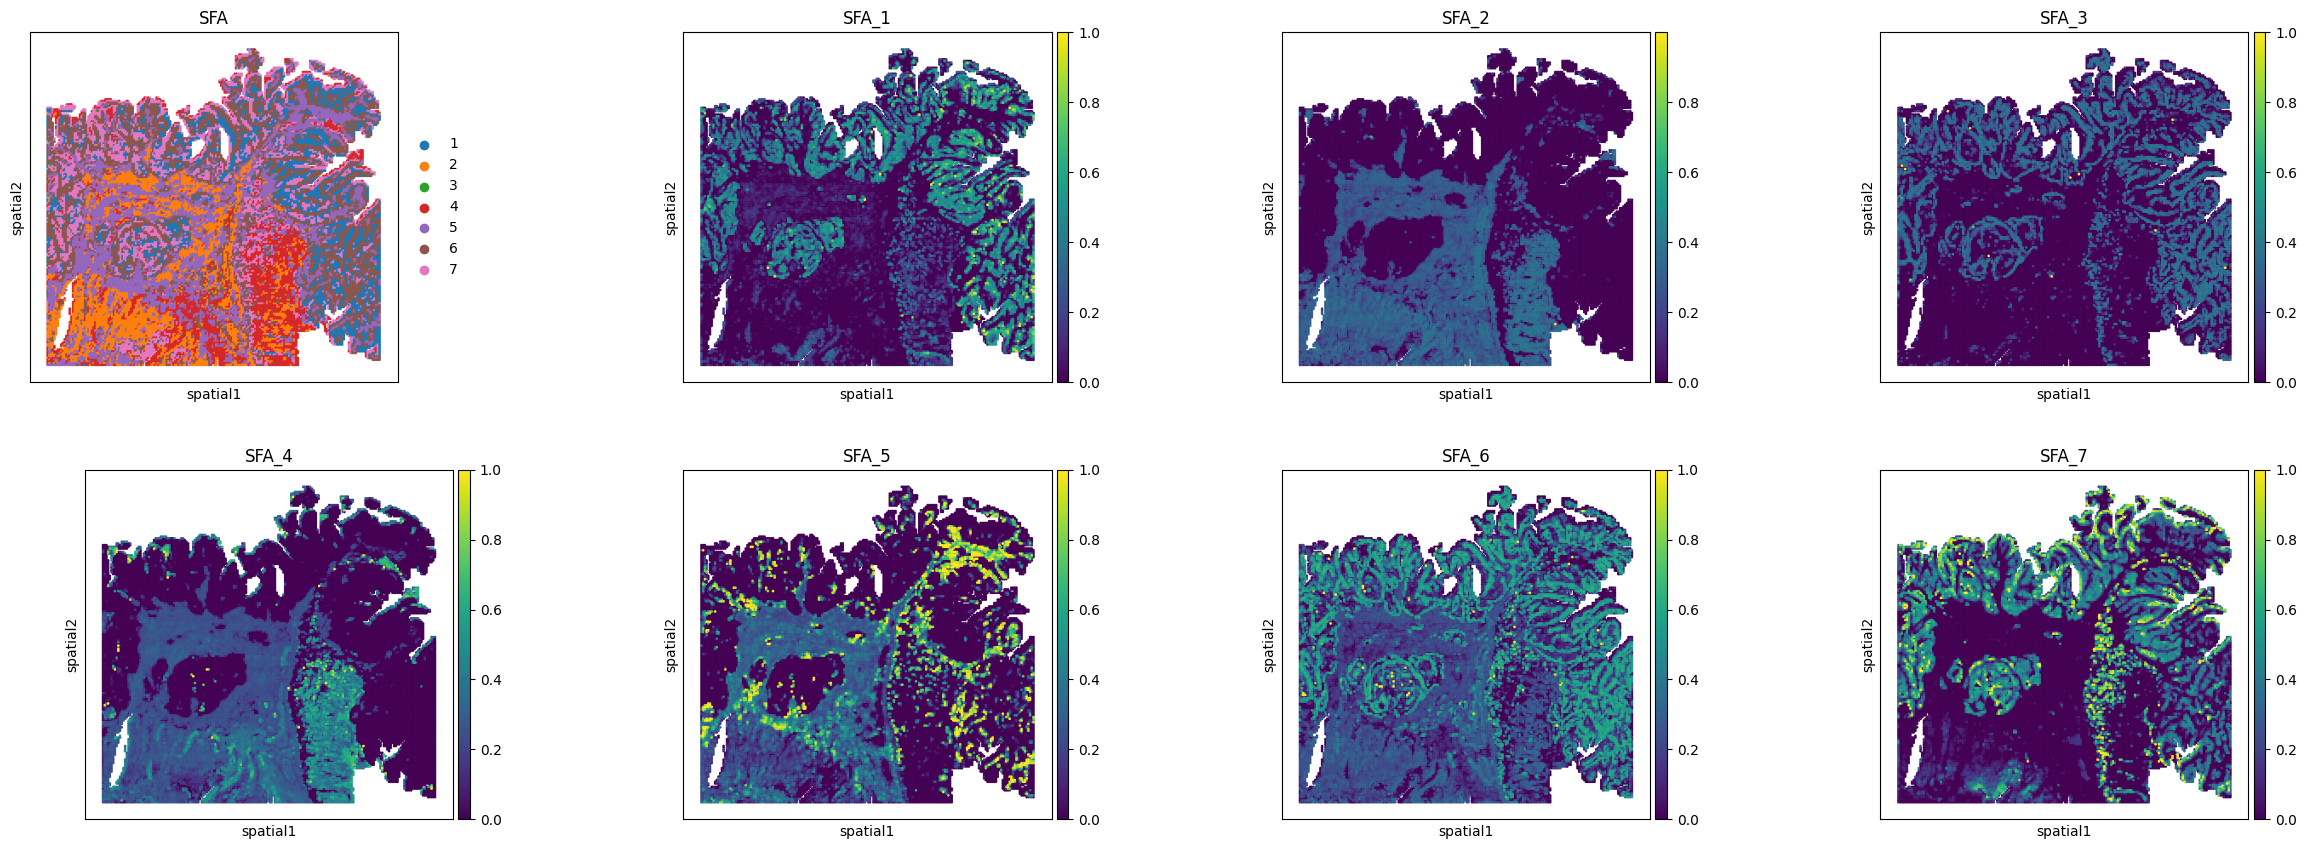

In [ ]:
sc.pl.spatial(adata_ext, color=['SFA', 'SFA_1','SFA_2','SFA_3','SFA_4','SFA_5','SFA_6', 'SFA_7'], spot_size=200)